# Twitter trolls - how Russia meddles with western democracies


## Abstract
Over the last several years there has been an attempt from Russian trolls to spread propaganda and fake news over social media in order to spread political ideas among the general population both nationally and internationally. Can these attempts be regarded as undermining the democracy of the affected countries?

In this project we are going to analyze a great number of these russian tweets and look into their motivations for this meddling. We will mainly look into their overall political goals in the US, and examine how these goals change over time. Have the trolls achieved their goals? We will also look into how the trolls operate and organize themselves, trying to find patterns in the madness. Such patterns can hopefully help the general population to indicate that a tweet is originating from a troll. As the Russian efforts are increasing every year, a solution is needed to defend the democracy.

## Research questions

-Which themes does the propaganda mainly revolve around? About which issues should people be particularly careful not to believe everything they read?
-Words
-most common word
-names
-consensus
-checking most common words in set above 3 characters (most common 4grams)

-Does the trolls advocate for a common political stance in each specific country? If so which leaning do they have? If not, how polarized are the tweets between left leaning and right leaning?
-groupby region, category

-Were the trolls united with a common political leaning in the period after the primaries in the US elections?


-Was the original mission of the Russian trolls for the US election to make sure that Clinton was not elected, or to get Trump elected?

-Are the trolls organized as a unit? Do they interact with each other (retweets, etc)?

-Is there a way for people without a technical background to determine if a tweet is coming from a Russian troll?

## Research questions

IRA russian twitter trolls - Three million tweets amounting to 175 Mb, along with a detailed description of the dataset

This dataset contains around three million tweets and retweets from 2848 unique twitter users. Each tweet has several attributes, some of them are extracted from the tweet itself. For instance the author, content, and time stamp. Other attributes are later added. An example of such attributes is category of the troll, e.g. RightTroll, NewsFeed, etc.

There are many factors that we can examine in the dataset. Looking at given features like timing could be very interesting to find patterns. We also intend to add features, in order to make the dataset more suitable for our analysis. As every data point contains the whole tweet itself, it is possible to perform a broad analysis on the content. This could be used to determine whether a certain person or word is mentioned, and add the overall theming as a feature. Another example of a possible extra feature is stating whether a tweet is a retweet of another troll, unique, or identical to another tweet in the set.

The data set it pretty small so it should be pretty manageable to process with pandas, but spark could also be used.

## Requierements

The second task is to intimately acquaint yourself with the data, preprocess it and complete all the necessary descriptive statistics tasks. We expect you to have a pipeline in place, fully documented in a notebook, and show us that you’ve advanced with your understanding of the project goals by updating its README description.

When describing the data, in particular, you should show (non-exhaustive list):

- That you can handle the data in its size.
- That you understand what’s into the data (formats, distributions, missing values, correlations, etc.).
- That you considered ways to enrich, filter, transform the data according to your needs.
- That you have updated your plan in a reasonable way, reflecting your improved knowledge after data acquaintance. In particular, discuss how your data suits your project needs and discuss the methods you’re going to use, giving their essential mathematical details in the notebook.
- That your plan for analysis and communication is now reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

We will evaluate this milestone according to how well these previous steps (or other reasonable ones) have been done and documented, the quality of the code and its documentation, the feasibility and critical awareness of the project.

## Description of second data set: 

- rus_troll_user.csv : Contains user specific features. (nickname, description field, follower count etc.)
- rus_troll_tweet_text.csv: Contains text and language of the given tweet. You will use this if you are doing text classification, sentiment analysis, topic detection etc. 
- rus_troll_tweet_metadata.csv: Contains features that are user specific, but may change tweet to tweet.
- rus_troll_tweet_stats.csv: Contains other (imo important) tweet features

In [1]:
# Add your imports here
import pandas as pd
import numpy as np
import seaborn as sns
from zipfile import ZipFile
from langdetect import detect
import scipy as sp
from pyspark.sql import *
from pyspark.sql.functions import *
%matplotlib inline
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from statistics import median 
import pyspark.sql.functions as func


spark = SparkSession.builder.getOrCreate()


**We start by loading the 9 files into a unified dataframe, we decide to use pandas, as the dataset is not too large, and especially when we focus on a subset of these tweets.**

In [2]:
zip_file = ZipFile('russian-troll-tweets.zip')
data = pd.DataFrame()
for i in range(1,9):
    data = data.append(pd.read_csv(zip_file.open("IRAhandle_tweets_"+str(i)+".csv")))
data=data.reset_index()
data.tail(5)

,index,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
2935811,378290,1.513801e+09,YOUJUSTCTRLC,They'll say some shit anonymously like a cowar...,United States,English,1/7/2017 7:47,1/7/2017 7:48,2655,2724,3007,RETWEET,left,0,1,LeftTroll
2935812,378291,1.513801e+09,YOUJUSTCTRLC,Mr. Brown knees https://t.co/LmAiHCnFlz,United States,English,1/7/2017 7:47,1/7/2017 7:48,2655,2724,3006,RETWEET,left,0,1,LeftTroll
2935813,378292,1.513801e+09,YOUJUSTCTRLC,"Like, you want somebody who follows you regula...",United States,English,1/7/2017 7:47,1/7/2017 7:47,2655,2724,3005,RETWEET,left,0,1,LeftTroll
2935814,378293,1.513801e+09,YOUJUSTCTRLC,"If you wanna ask me something, ask it here so ...",United States,English,1/7/2017 7:48,1/7/2017 7:48,2655,2724,3008,RETWEET,left,0,1,LeftTroll
2935815,378294,1.513801e+09,YOUJUSTCTRLC,And there he is again ... Inside the KGB Playb...,United States,English,1/8/2017 1:56,1/8/2017 1:57,2655,2724,3013,RETWEET,left,0,1,LeftTroll


We see that the dataframe contains certain columns that does not serve a purpose for our project. We decide to remove these. We decide to drop the column saying weether or not a row is a retweet or not, as we have this information in "post_type".
In order to be able to perform comparisons on the datestamp we convert this to datetime. We also inspect the distinct post types, as we can see that there are several NaN values.

In [3]:
data = data.drop(columns=["index","harvested_date","new_june_2018","retweet"])
data["publish_date"] =   pd.to_datetime(data["publish_date"], format='%m/%d/%Y\n%H:%M')
data = data.sort_values("publish_date")
data["post_type"].unique()

array([nan, 'RETWEET', 'QUOTE_TWEET'], dtype=object)

**We see that there are only three unique values for post_type. As tweets authored by the user itself are not represented in these values, we decide to replace the NaN values with a value saying that a tweet is original.**

In [4]:
data["post_type"] = data["post_type"].fillna("ORIGINAL_TWEET")

In [5]:
zip_file_new = ZipFile("New_russian_tweets.zip")
new_text = pd.read_csv(zip_file_new.open("rus_troll_tweet_text.csv"))
new_text = new_text[new_text["tweet_language"]=="en"].drop(columns=["tweet_language"])
new_metadata = pd.read_csv(zip_file_new.open("rus_troll_tweet_metadata.csv")).drop(columns=["latitude","longitude","tweet_client_name"])
new_metadata.columns=["tweetid","following","followers"]
new_user = pd.read_csv(zip_file_new.open("rus_troll_user.csv")).drop(columns=["user_display_name","user_screen_name","user_profile_description","user_profile_url"])
new_tweets= pd.merge(new_text, new_metadata, on='tweetid')
new_stats = pd.read_csv(zip_file_new.open("rus_troll_tweet_stats.csv")).drop(columns=["poll_choices","urls"])
new_tweets= pd.merge(new_tweets,new_stats.filter(["tweetid","userid","tweet_time"]) , on='tweetid')
#new_tweets= pd.merge(new_tweets,new_stats.filter(["tweetid","userid","tweettime"],axis=1) , on='tweetid')

/Users/Skolebruker/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
retweets = new_stats[new_stats["is_retweet"]==True]
retweets = new_tweets[new_tweets["tweetid"].isin(retweets["tweetid"].tolist())]
retweets["post_type"] ="RETWEET"
quote_tweets = new_stats[np.isfinite(new_stats['quoted_tweet_tweetid'])]
quote_tweets = new_tweets[new_tweets["tweetid"].isin(quote_tweets["tweetid"].tolist())]
quote_tweets = quote_tweets[~quote_tweets["tweetid"].isin(retweets["tweetid"].tolist())]
quote_tweets["post_type"] = "QUOTE_TWEET"
unoriginal_tweets = quote_tweets.append(retweets)
orig_tweets= new_tweets[~new_tweets["tweetid"].isin(unoriginal_tweets["tweetid"])]
orig_tweets["post_type"] = "ORIGINAL_TWEET"
new_tweets = unoriginal_tweets.append(orig_tweets)

/Users/Skolebruker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Skolebruker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [11]:
new_tweets.to_parquet('tweets.parquet.gzip', compression='gzip')
tweets_spark = spark.read.parquet('tweets.parquet.gzip')
tweets_spark.show()

+------------------+--------------------+---------+---------+--------------------+----------------+-----------+-----------------+
|           tweetid|          tweet_text|following|followers|              userid|      tweet_time|  post_type|__index_level_0__|
+------------------+--------------------+---------+---------+--------------------+----------------+-----------+-----------------+
|653251376760295425|I need this skill...|    22035|     9795|          2882350436|2015-10-11 16:50|QUOTE_TWEET|               12|
|748448356297498626|Getting richer wi...|    20019|    14112|          3978316814|2016-06-30 09:29|QUOTE_TWEET|               42|
|815037019973763073|Can't blame @real...|     2748|      265|a95a911dd6ae864c4...|2016-12-31 03:29|QUOTE_TWEET|              199|
|805940400229740545|Damn, look at dis...|     2748|      265|a95a911dd6ae864c4...|2016-12-06 01:02|QUOTE_TWEET|              277|
|786297829459308544|4 days and 5 hour...|     2748|      265|a95a911dd6ae864c4...|2016-10-

# Are the trolls organized as a unit?

**Now that we have a clean dataset, we take a look at how many tweets are originating from each region.**

In [79]:
data.groupby(["region"]).size()


region
Afghanistan                     3319
Austria                            1
Azerbaijan                     98437
Belarus                        29152
Canada                           608
Czech Republic                     7
Denmark                            1
Egypt                            232
Estonia                            1
Finland                           20
France                           942
Germany                        27192
Greece                            91
Hong Kong                          3
India                             22
Iran, Islamic Republic of        541
Iraq                           11202
Israel                          3600
Italy                          13494
Japan                            110
Latvia                             7
Malaysia                        4933
Mexico                            41
Russian Federation             37094
Samoa                             32
Saudi Arabia                       7
Serbia                         

We see from  that there are a lot of regions affected by Russian interference. Not surprisingly tweets in United states account for more than two thirds of our dataset, this comes as no surprise as this meddling is regarded as the most focused. 

We also see a lot of other regions with a lot of tweets. Azerbaijan, Belarus, Germany, Iraq, Italy, Russia, UAE and UK all have more than 10000 tweets labeled to them. 

It makes a lot of sense that Russia itself is a major target, as one can expect that influencing ones own population is an important way of staying in power, and achieving political goals.  

Azerbaijan and UAE is contrary to our expectations the countries with the second, and third, largest amount of tweets from trolls. Our expectations was that UK, Germany and Italy would be a bigger target as these countries are all part of NATO and as of now the EU. Which all regard Russia as a hostile nation. Weakening the political stability and advocating for leaving such organizations would therefore seem like an obvious goal for Russian trolls.

In order to try to make some sense of this we take a look at the languages used in these countries.

In [80]:
data[data["region"].isin(["Azerbaijan","United Arab Emirates"])].groupby(["language","region"]).size().to_frame().unstack(level=-1)


0                     
region             Azerbaijan United Arab Emirates
language                                          
Albanian                  3.0                  1.0
Arabic                   39.0                 26.0
Bulgarian              1216.0                856.0
Catalan                   5.0                  NaN
Croatian                 12.0                  2.0
Czech                    10.0                  1.0
Dutch                     5.0                  NaN
English                7611.0                281.0
Estonian                  4.0                  NaN
Farsi (Persian)           9.0                  3.0
Finnish                   2.0                  NaN
French                   30.0                861.0
German                   18.0                  6.0
Greek                     1.0                  NaN
Gujarati                  1.0                  NaN
Hebrew                    4.0                  3.0
Icelandic                 2.0                  NaN
Indonesian                2.0                  NaN
Italian                  46.0                  2.0
Japanese                  2.0                  NaN
Kurdish                   8.0                  2.0
LANGUAGE UNDEFINED       47.0                 27.0
Latvian                   5.0                  NaN
Lithuanian                2.0                  NaN
Macedonian              720.0                674.0
Malay                     NaN                  1.0
Norwegian                17.0                  2.0
Polish                    2.0                  NaN
Portuguese                3.0                  NaN
Pushto                    6.0                  NaN
Romanian                 10.0                  1.0
Russian               80593.0              62382.0
Serbian                1132.0               1057.0
Simplified Chinese        2.0                  4.0
Slovak                    2.0                  NaN
Slovenian                 2.0                  NaN
Spanish                  73.0                  4.0
Swedish                   2.0                  NaN
Tagalog (Filipino)        1.0                  NaN
Turkish                   6.0                  NaN
Ukrainian              5488.0               4264.0
Uzbek                  1289.0                915.0
Vietnamese                5.0                  NaN

We see that an overwhelming majority of the tweets in both countries are written in russian. For Azerbaijan where the official language is Azerbaijani, a language that is close to russian, these tweets might be directed at the population. However, the population of UAE mainly speak Arabic, European and asian languages. The fact that so few tweets in this region are written in Arabic and English indicates that the tweets are meant for people outside of the region. Why the trolls follow this approach in this country is a mystery to us, and is something that we hope someone with knowledge about the Russian language will look into.

After inspecting some of the tweets we conclude that a lot of the language stamps do not match, the actual tweets. For instance, most of the tweets labeled to our mothertongue Norwegian was English. The same went for different languages, such as those of neighbouring countries like Danish and Swedish. For this reason we decide to discard all tweets in other languages than english, in order to avoid confusion. We could have included tweets in other languages of which we have some knowledge of, we decide not to as we have limited knowledge of the political climate in these countries. The labeling of english tweets are also better, and our decision also helps keeping the scope of the project limited.

In [81]:
data = data.loc[data['language'] == "English"]
data.head(10)


,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
687349,4.437234e+09,CRYSTAL1JOHNSON,Resale homes sales R up. As we learned from th...,United States,English,2012-02-06 20:24:00,4,0,2,ORIGINAL_TWEET,left,LeftTroll
687369,4.437234e+09,CRYSTAL1JOHNSON,Good morning! There is so much we have to be t...,United States,English,2012-02-07 13:24:00,4,0,4,ORIGINAL_TWEET,left,LeftTroll
687391,4.437234e+09,CRYSTAL1JOHNSON,The reality is becoming increasingly pellucid:...,United States,English,2012-02-08 13:37:00,7,0,4,ORIGINAL_TWEET,left,LeftTroll
686933,4.437234e+09,CRYSTAL1JOHNSON,“The content of your character is your choice....,United States,English,2012-02-14 12:45:00,7,1,8,ORIGINAL_TWEET,left,LeftTroll
687259,4.437234e+09,CRYSTAL1JOHNSON,"""Coming together is a beginning. Keeping toget...",United States,English,2012-02-29 14:32:00,7,2,9,ORIGINAL_TWEET,left,LeftTroll
688172,4.437234e+09,CRYSTAL1JOHNSON,What lies behind us and what lies between us a...,United States,English,2012-03-07 14:42:00,7,2,9,ORIGINAL_TWEET,left,LeftTroll
688194,4.437234e+09,CRYSTAL1JOHNSON,"""I immerse my mind with good positive thoughts...",United States,English,2012-03-08 14:25:00,7,2,11,ORIGINAL_TWEET,left,LeftTroll
687494,4.437234e+09,CRYSTAL1JOHNSON,To Follow or Not To Follow: Should Small Busin...,United States,English,2012-03-12 05:32:00,7,2,12,ORIGINAL_TWEET,left,LeftTroll
687603,4.437234e+09,CRYSTAL1JOHNSON,Interest Rates are on the move: the biggest ju...,United States,English,2012-03-16 12:42:00,7,2,14,ORIGINAL_TWEET,left,LeftTroll
687604,4.437234e+09,CRYSTAL1JOHNSON,“My philosophy is that not only r u responsibl...,United States,English,2012-03-16 12:42:00,7,2,13,ORIGINAL_TWEET,left,LeftTroll


After sorting out all non-English tweets, we again look at which regions are most prominent in the data. 

In [12]:
english_tweets_countries = data.groupby(["region"]).size().to_frame()
english_tweets_countries 

,0
region,
Afghanistan,3319
Austria,1
Azerbaijan,98437
Belarus,29152
Canada,608
Czech Republic,7
Denmark,1
Egypt,232
Estonia,1


Strangely, even after removing all but english-labeled columns we have lot of regions represented in our dataset. After inspecting the english tweets from azerbaijan, we find that most tweets are retweets. We suspect this might be the case for the other non-english speaking countries. We therefore decide to plot a stacked bar chart to see how the distribution of the tweet types behave in different regions. We set a treshold of how many tweets originate from a country, in order to avoid countries with a very small amount of tweets.

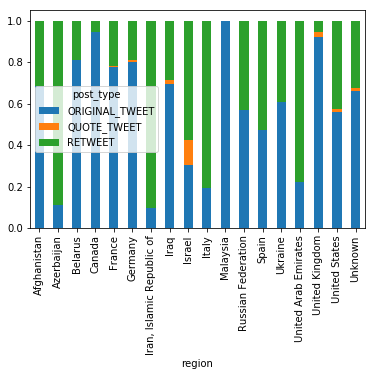

In [13]:
tweet_type_countries=pd.DataFrame(data.groupby(["region","post_type"]).size()).unstack(level=-1)
tweet_type_countries = tweet_type_countries[english_tweets_countries[0]>400]
tweet_type_countries.columns = tweet_type_countries.columns.droplevel()
tweet_type_countries = tweet_type_countries.loc[:,"ORIGINAL_TWEET":"RETWEET"].div(tweet_type_countries.sum(axis=1), axis=0)
tweet_type_countries.plot.bar(stacked=True)

**We see that the three english speaking countries Canada, UK and USA, all have more original tweets than retweets. Compare this to countries like Azerbaijan, Belarus and Iraq, we see that english retweets are far more prominent than original tweets. We do, however, see that there are other countries, that we expect to have been important targets, that have a much larger concentration of english original tweets. This is particularly true for Germany and Italy. We also note that a very high percentile of the tweets with unknown origin are original tweets. If unknown tweets are spread in a distribution close to the tweets with known origin, one would assume that an overwhelming majority of these tweets originates from the USA, and that the ratio of original tweets would be similar to that of the US. However the tweets with unknown origin have a way higher ratio of original tweets.** 

We hypothesize that original tweets are regarded as more influential to the audience of the tweet, and that the russians therefore prefer these in targeted countries with a high percentage of english speakers such as UK, USA and Germany. Retweets, on the other hand, can be a useful tool to push the retweet count of certain tweets up, in order to increase their legitimacy in the eyes of the viewer. What country these retweets come from does not matter, and it therefore makes sense that the retweet percentage is so high in contries like Azerbaijan and Russia. 

**In order to test our hypothesis we take a look at tweets that have the same content, and look group them into their post type**

In [ ]:
aggregate = data.groupby(["content","post_type"]).size().to_frame().unstack(level=-1)
new_aggregate = tweets_spark.groupBy("tweet_text").pivot(
        "post_type").agg(count('*')).orderBy(asc("RETWEET"))
aggregate.columns = aggregate.columns.droplevel()
aggregate = aggregate.sort_values("RETWEET",ascending=False)

aggregate.head(20)

In [ ]:
n_agg_pandas = new_aggregate.toPandas()
n_agg_pandas.head(10)

Interestingly we see that a lot of tweets are the same except for different links. We decide to split on the keyword "http", discard the last part and strip the remianing part, in order to make sure that minor changes are not taken into account.

In [ ]:
stripped_data = data
stripped_data["content"]=data["content"].apply(lambda s: str(s).split("https")[0].strip())
aggregate_stripped = data.groupby(["content"]).size().sort_values(ascending=False)
display(aggregate_stripped)


Top two rows are empty, meaning that they only contained links, we disregard these.

In [ ]:
aggregate_stripped.drop(aggregate_stripped.index[[0]], inplace=True)
aggregate_stripped.hist(bins=20, figsize=(8,6), xlabelsize=15, ylabelsize=15, log =True)

we see that most tweets are only written once. However, approximately a quarter of the tweets are not unique.

In [ ]:
len(data)

In [ ]:
aggregate_df = pd.DataFrame(aggregate_stripped.reset_index())
aggregate_df = aggregate_df[aggregate_df[0] >1]

In [ ]:
retweets = data[data["post_type"] == "RETWEET"]
origin_tweets = data[data["post_type"] != "RETWEET"]

In [ ]:
retweets_with_duplicates = retweets[retweets["content"].isin( aggregate_df["content"].tolist())]

tweets_with_duplicates = origin_tweets[origin_tweets["content"].isin( aggregate_df["content"].tolist())]
retweets_within_set = retweets_with_duplicates[retweets_with_duplicates["content"].isin(tweets_with_duplicates["content"])]
tweets_retweeted_within_set = tweets_with_duplicates[tweets_with_duplicates["content"].isin(retweets_with_duplicates["content"])]

In [ ]:
print(len(retweets_with_duplicates),len(tweets_with_duplicates), len(retweets_within_set),len(tweets_retweeted_within_set))
#retweets_with_duplicates["publish_date"].apply(lambda x: check_earlier(x,originals))

In [ ]:
retweets_within_set.groupby(["region"]).size()